# LDA topic modeling

- Extract features using LDA
- Evaluate usefullness using XGBoost

## Data loading & exploration

In [1]:
# Import data
import pandas as pd

ori_papers = pd.read_csv('/home/xiaopengxu/Desktop/covid-review/data-covid-review/2021-05-31/compdata_ext_ref.csv', index_col=False)

In [2]:
ori_papers['title'] = ori_papers['title'].fillna('NULL')
papers = ori_papers.drop_duplicates(subset=['title'])
papers.drop(['Unnamed: 0'], axis=1, inplace=True)

/home/xiaopengxu/anaconda3/envs/ml-env/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Preprocessing

In [3]:
import re

doc_words = papers['abstract'].map(lambda x: re.sub('[,\:\.!?]', ' ', x)) #use only abstracts

In [4]:
# Tokenize &# Lemmatize the documents.
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
doc_tokenizers = doc_words.apply(lambda x : tokenizer.tokenize(x.lower()))

lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in doc_tokenizers]

In [5]:
# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

/home/xiaopengxu/anaconda3/envs/ml-env/lib/python3.8/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [6]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 9457
Number of documents: 16896


## LDA modeling

In [49]:
import time
from gensim.models import LdaMulticore, CoherenceModel


def compute_coherence(corpus, dictionary, docs, num_topics=6, coherence='c_v'):
    temp = dictionary[0] # This is only to "load" the dictionary.
    id2word = dictionary.id2token

    lda_model = LdaMulticore(corpus=corpus,
                             id2word=id2word,
                             num_topics=num_topics,
                             random_state=100,
                             chunksize=100)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence=coherence)
    coherence_lda = coherence_model_lda.get_coherence()
    
    print(f'{time.strftime("%H:%M:%S", time.localtime())} topics={num_topics}, coherence score: {coherence_lda}')
    
    return coherence_lda

In [56]:
import matplotlib.pyplot as plt

def plot_coh(x_axis, y_axis, tag='0', x_label='Topic numbers', y_label='Coherence Score', title='Coherence score for different number of topics'):

    plt.figure()
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.plot(x_axis, y_axis, label=tag)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend(loc='best')
    fig1 = plt.gcf()
    plt.show()
    plt.draw()
    fig1.savefig(f'Topic_coherence_{tag}.png', dpi=100)

In [51]:
import numpy as np

# Topic range parameter
n_topics = np.arange(4, 20+1)
print(f'n_topics = {n_topics}')

n_topics = [ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


17:54:34 topics=4, coherence score: 0.23836880627784796
17:54:42 topics=5, coherence score: 0.23824188945724356
17:54:50 topics=6, coherence score: 0.2511233657526389
17:54:58 topics=7, coherence score: 0.2471977091102878
17:55:06 topics=8, coherence score: 0.25342273590961273
17:55:14 topics=9, coherence score: 0.2487131337613283
17:55:22 topics=10, coherence score: 0.259521335544943
17:55:31 topics=11, coherence score: 0.2565587294228853
17:55:39 topics=12, coherence score: 0.26501170503433
17:55:47 topics=13, coherence score: 0.26690141009541934
17:55:56 topics=14, coherence score: 0.27111684530077984
17:56:05 topics=15, coherence score: 0.28377917438449507
17:56:15 topics=16, coherence score: 0.2808228274193062
17:56:25 topics=17, coherence score: 0.2854695227304424
17:56:34 topics=18, coherence score: 0.277720206844107
17:56:43 topics=19, coherence score: 0.27946865608814586
17:56:53 topics=20, coherence score: 0.2770158097659812


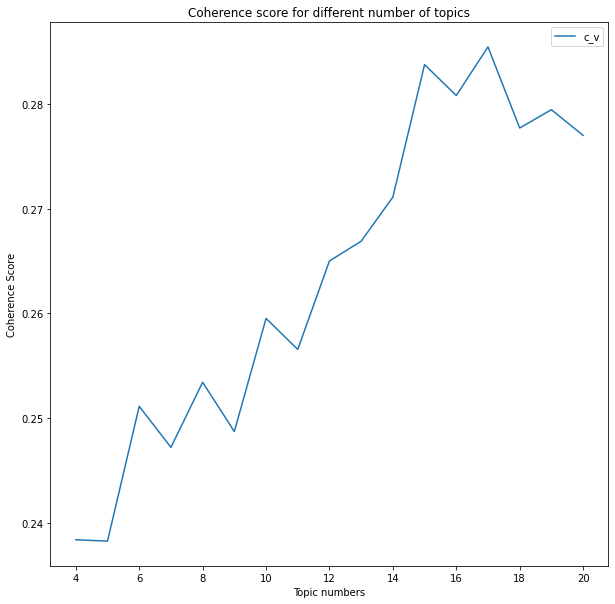

<Figure size 720x720 with 0 Axes>

In [57]:
# Evaluate topic number using c_v
# iterate through number of topics
np_coh = np.zeros(len(n_topics))
for i in range(len(n_topics)):
    cv = compute_coherence(corpus, dictionary, docs, num_topics=n_topics[i])
    np_coh[i] = cv

plot_coh(n_topics, np_coh, tag='c_v')

17:57:33 topics=4, coherence score: -1.0230927563283856
17:57:39 topics=5, coherence score: -0.9891890822736503
17:57:46 topics=6, coherence score: -0.9745373805525697
17:57:53 topics=7, coherence score: -1.0065435015695334
17:57:59 topics=8, coherence score: -1.0191564124423307
17:58:05 topics=9, coherence score: -1.0312617752875926
17:58:12 topics=10, coherence score: -1.0294020030882203
17:58:19 topics=11, coherence score: -1.0388913136926512
17:58:26 topics=12, coherence score: -1.034633465102906
17:58:33 topics=13, coherence score: -1.0444756704143812
17:58:41 topics=14, coherence score: -1.0511565389963526
17:58:48 topics=15, coherence score: -1.0668812413849347
17:58:56 topics=16, coherence score: -1.061409205228887
17:59:04 topics=17, coherence score: -1.0607407839653828
17:59:12 topics=18, coherence score: -1.0604803429763179
17:59:20 topics=19, coherence score: -1.085250144785304
17:59:27 topics=20, coherence score: -1.0694019093783447


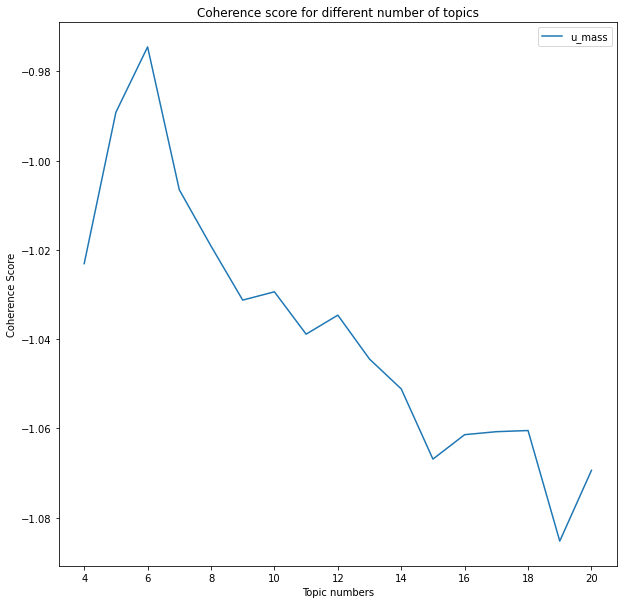

<Figure size 720x720 with 0 Axes>

In [58]:
# Evaluate topic number
# iterate through number of topics
np_coh = np.zeros(len(n_topics))
for i in range(len(n_topics)):
    u_mass = compute_coherence(corpus, dictionary, docs, num_topics=n_topics[i], coherence='u_mass')
    np_coh[i] = u_mass

plot_coh(n_topics, np_coh, tag='u_mass')

In [66]:
import matplotlib.pyplot as plt

def plot_coh_errbar(x, y, err, tag='0', x_label='Topic numbers', y_label='Coherence Score', title='Coherence score for different number of topics'):

    plt.figure()
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.errorbar(x, y, yerr=err, fmt='-o', label=tag)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend(loc='best')
    fig1 = plt.gcf()
    plt.show()
    plt.draw()
    fig1.savefig(f'Topic_coherence_{tag}.png', dpi=100)

18:09:03 topics=4, coherence score: -1.024398253243128
18:09:09 topics=4, coherence score: -1.0229749098108565
18:09:15 topics=4, coherence score: -1.0245249992252958
18:09:22 topics=4, coherence score: -1.0273016106387385
18:09:29 topics=4, coherence score: -1.0212066269573028
18:09:35 topics=5, coherence score: -0.9796238820362484
18:09:42 topics=5, coherence score: -0.9891890822736503
18:09:48 topics=5, coherence score: -0.9809534374101478
18:09:55 topics=5, coherence score: -0.9795102686855082
18:10:01 topics=5, coherence score: -0.9893992116199332
18:10:08 topics=6, coherence score: -0.9792913869028806
18:10:14 topics=6, coherence score: -0.9710329041296039
18:10:21 topics=6, coherence score: -0.9697770050689529
18:10:28 topics=6, coherence score: -0.973863926129666
18:10:34 topics=6, coherence score: -0.9820816804078797
18:10:40 topics=7, coherence score: -1.0042534654615674
18:10:47 topics=7, coherence score: -1.0071843681474508
18:10:53 topics=7, coherence score: -1.00531049512

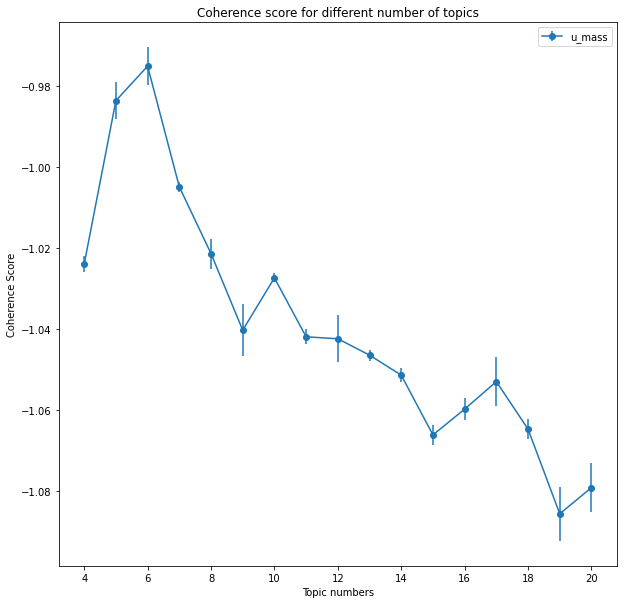

<Figure size 720x720 with 0 Axes>

In [68]:
# Evaluate topic number
# iterate through number of topics
times = 5 # how many times for each run 

np_coh = np.zeros((len(n_topics), times))
for i in range(len(n_topics)):
    for j in range(times):
        u_mass = compute_coherence(corpus, dictionary, docs, num_topics=n_topics[i], coherence='u_mass')
        np_coh[i,j] = u_mass

np_coh_mean = np_coh.mean(axis=-1)
np_coh_std = np_coh.std(axis=-1)
plot_coh_errbar(n_topics, np_coh_mean, np_coh_std, tag='u_mass')